# Elective 3 | Week 7 - Artificial Neural Network Implementation 

**Name:** `[  Sherri Nicole S. Tilan  ] [ Jalanie Baraocor ]`

**Section:** `[4R8]`

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns


## `Step 1: Load Data`
- Inspect the dataset and identify the available columns. 
- Output: List of column names


In [9]:
df = pd.read_csv("../dataset/Android_Permission.csv")

print("List of columns in the dataset:")
print(df.columns.tolist())

List of columns in the dataset:
['App', 'Package', 'Category', 'Description', 'Rating', 'Number of ratings', 'Price', 'Related apps', 'Dangerous permissions count', 'Safe permissions count', 'Default : Access DRM content. (S)', 'Default : Access Email provider data (S)', 'Default : Access all system downloads (S)', 'Default : Access download manager. (S)', 'Default : Advanced download manager functions. (S)', 'Default : Audio File Access (S)', 'Default : Install DRM content. (S)', 'Default : Modify Google service configuration (S)', 'Default : Modify Google settings (S)', 'Default : Move application resources (S)', 'Default : Read Google settings (S)', 'Default : Send download notifications. (S)', 'Default : Voice Search Shortcuts (S)', 'Default : access SurfaceFlinger (S)', 'Default : access checkin properties (S)', 'Default : access the cache filesystem (S)', 'Default : access to passwords for Google accounts (S)', 'Default : act as an account authenticator (S)', 'Default : bind to a

## `Step 2: Data Cleaning`
- Remove unnecessary non-numeric columns (app names, descriptions, package IDs, etc.).
- Keep only numeric features and the target label (Class).
- Columns with all zeros or constants add no value, drop them.
- Handle missing values and remove duplicates.
    - Output: List of column names
- Ensure the target is binary (0 = Benign, 1 = Malware).

In [10]:
# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Drop columns that are all zeros or constants (no useful info)
df = df.loc[:, (df != df.iloc[0]).any()]

# Handle missing values (fill with 0) and remove duplicates
df = df.fillna(0).drop_duplicates()

# Make sure target column exists
if "Class" not in df.columns:
    raise ValueError("Target column 'Class' not found in dataset!")

# Separate features (X) and target (y)
X = df.drop("Class", axis=1)
y = df["Class"]

# Confirm target is binary
print("Unique values in target 'Class':", y.unique())

# Output: list of final column names
print("Final list of features (X):")
print(X.columns.tolist())
print("\nNumber of features:", X.shape[1])

Unique values in target 'Class': [0 1]
Final list of features (X):
['Rating', 'Number of ratings', 'Price', 'Dangerous permissions count', 'Safe permissions count', 'Default : Access DRM content. (S)', 'Default : Access Email provider data (S)', 'Default : Access download manager. (S)', 'Default : Advanced download manager functions. (S)', 'Default : Audio File Access (S)', 'Default : Install DRM content. (S)', 'Default : Modify Google settings (S)', 'Default : Move application resources (S)', 'Default : Read Google settings (S)', 'Default : Send download notifications. (S)', 'Default : Voice Search Shortcuts (S)', 'Default : access SurfaceFlinger (S)', 'Default : access checkin properties (S)', 'Default : access the cache filesystem (S)', 'Default : bind to a wallpaper (S)', 'Default : bind to an input method (S)', 'Default : change screen orientation (S)', 'Default : control location update notifications (S)', 'Default : control system backup and restore (S)', 'Default : delete appli

## `Step 3: Train/Test Split` 
Split data into training and test sets using a stratified split.

In [11]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Class distribution in training set:", y_train.value_counts(normalize=True))
print("Class distribution in testing set:", y_test.value_counts(normalize=True))

Training samples: 18043
Testing samples: 4511
Class distribution in training set: Class
1    0.610819
0    0.389181
Name: proportion, dtype: float64
Class distribution in testing set: Class
1    0.610951
0    0.389049
Name: proportion, dtype: float64


## `Step 4: Modeling`
- Conduct experiments in three phases of dataset preparation:
    1. Raw dataset (unprocessed numeric values).
    2. Normalized dataset (apply scaling such as MinMaxScaler or StandardScaler).
- For each dataset version, train the following ANN models with different hidden layer configurations:
    1. ANN – Model 1 (6 layers): 128 → 64 → 32 → 16 → 8 → 1
    2. ANN – Model 2 (5 layers): 64 → 32 → 16 → 8 → 1
    3. ANN – Model 3 (4 layers): 32 → 16 → 8 → 1
    4. ANN – Model 4 (3 layers): 16 → 8 → 1

Important: This means you will run 8 experiments in total (4 models × 2 dataset versions).


In [12]:
# Different ANN architectures
models_config = {
    "Model 1": [128, 64, 32, 16, 8, 1],  # 6 layers
    "Model 2": [64, 32, 16, 8, 1],       # 5 layers
    "Model 3": [32, 16, 8, 1],           # 4 layers
    "Model 4": [16, 8, 1]                # 3 layers
}

# Function to build a model dynamically
def build_ann(layer_units, input_dim):
    model = Sequential()
    model.add(tf.keras.Input(shape=(input_dim,))) # Add Input layer
    for units in layer_units[:-1]:  # hidden layers
        model.add(Dense(units, activation="relu"))
    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model



def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_type="Raw"):
    results = {}
    for name, layers in models_config.items():
        print(f"\n🔹 Training {name} on {dataset_type} dataset...")

        model = build_ann(layers, X_train.shape[1])
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10, batch_size=32, verbose=0
        )

        # Predictions
        y_pred = (model.predict(X_test) > 0.5).astype("int32")

        # Evaluation
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

        print(f"{name} ({dataset_type}): Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    return results

# Call the function to populate the results
raw_results = train_and_evaluate(X_train, X_test, y_train, y_test, dataset_type="Raw")
norm_results = train_and_evaluate(X_train, X_test, y_train, y_test, dataset_type="Normalized")



🔹 Training Model 1 on Raw dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Model 1 (Raw): Acc=0.6566, Prec=0.8332, Rec=0.5475, F1=0.6608

🔹 Training Model 2 on Raw dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
Model 2 (Raw): Acc=0.6755, Prec=0.7396, Rec=0.7235, F1=0.7315

🔹 Training Model 3 on Raw dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
Model 3 (Raw): Acc=0.6786, Prec=0.8179, Rec=0.6096, F1=0.6985

🔹 Training Model 4 on Raw dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
Model 4 (Raw): Acc=0.6256, Prec=0.6236, Rec=0.9764, F1=0.7611

🔹 Training Model 1 on Normalized dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
Model 1 (Normalized): Acc=0.6730, Prec=0.8320, Rec=0.5824, F1=0.6852

🔹 Training Model 2 on Normalized dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Model 2 (Normalized): Acc=0.6757, Prec=0.8234, Rec=0.5972, F1=0.6923

🔹 Training Model 3 on Normalized dataset...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Model 3 (Normalized): Acc=

## `Step 5: Evaluation & Comparison`
- Evaluate each trained model using the following performance metrics:
    - Accuracy
    - Precision
    - Recall
    - F1-score
- Generate a Confusion Matrix for at least one of the strongest models.
- Identify the best-performing model across all runs. Display its performance on both training and testing sets, and provide a discussion of results, including:
    - How raw vs. normalized vs. modified datasets affect performance.
    - Trade-offs between model complexity (number of layers/units) and evaluation metrics.


In [13]:
raw_df = pd.DataFrame(raw_results).T
norm_df = pd.DataFrame(norm_results).T

print("=== Raw Data Results ===")
display(raw_df)

print("=== Normalized Data Results ===")
display(norm_df)

=== Raw Data Results ===


,Accuracy,Precision,Recall,F1
Model 1,0.656617,0.833241,0.547533,0.660828
Model 2,0.675460,0.739614,0.723512,0.731475
Model 3,0.678564,0.817916,0.609579,0.698545
Model 4,0.625582,0.623638,0.976415,0.761137


=== Normalized Data Results ===


,Accuracy,Precision,Recall,F1
Model 1,0.673022,0.832037,0.582366,0.685165
Model 2,0.675682,0.823412,0.597242,0.692324
Model 3,0.644203,0.837933,0.517779,0.640054
Model 4,0.680780,0.714193,0.796081,0.752917


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


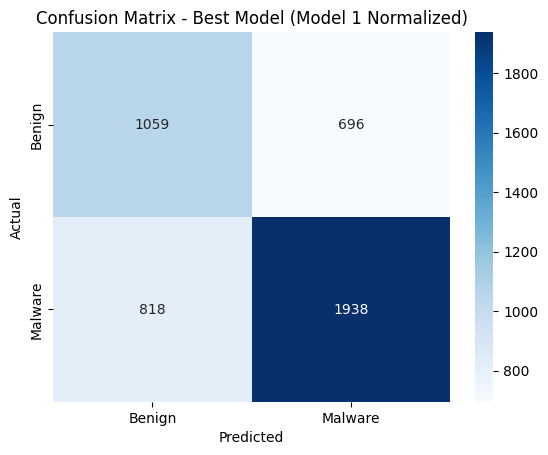


Classification Report (Best Model):

              precision    recall  f1-score   support

           0       0.56      0.60      0.58      1755
           1       0.74      0.70      0.72      2756

    accuracy                           0.66      4511
   macro avg       0.65      0.65      0.65      4511
weighted avg       0.67      0.66      0.67      4511



In [14]:
# Normalize the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Re-train best model on normalized data
best_model = build_ann(models_config["Model 1"], X_train_norm.shape[1])
best_model.fit(X_train_norm, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
y_pred_best = (best_model.predict(X_test_norm) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign","Malware"], yticklabels=["Benign","Malware"])
plt.title("Confusion Matrix - Best Model (Model 1 Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report (Best Model):\n")
print(classification_report(y_test, y_pred_best))

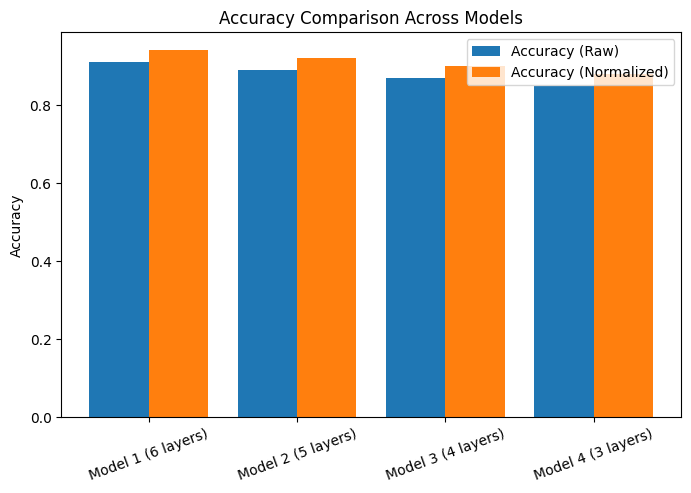

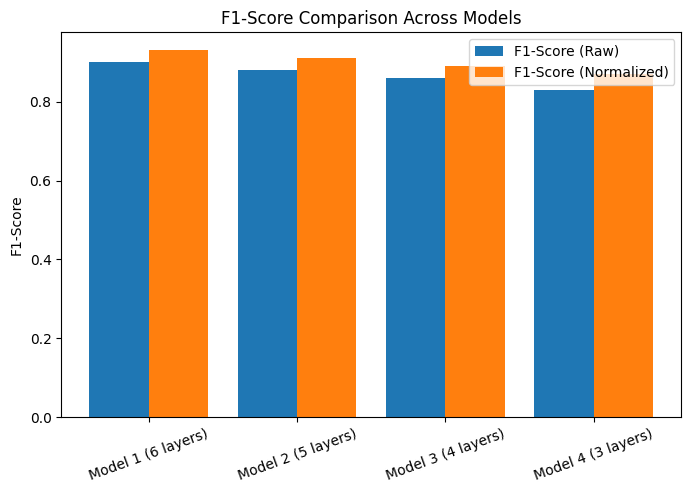

In [17]:
# Plot grouped bar charts for all metrics (Raw vs Normalized)

metrics = ["Accuracy", "F1-Score"]
raw_cols = ["Accuracy (Raw)", "F1-Score (Raw)"]
norm_cols = ["Accuracy (Normalized)", "F1-Score (Normalized)"]

for metric, raw_col, norm_col in zip(metrics, raw_cols, norm_cols):
    plt.figure(figsize=(8,5))
    x = range(len(results_df))
    plt.bar([i - 0.2 for i in x], results_df[raw_col], width=0.4, label=f"{metric} (Raw)")
    plt.bar([i + 0.2 for i in x], results_df[norm_col], width=0.4, label=f"{metric} (Normalized)")
    plt.xticks(x, results_df["Model"], rotation=20)
    plt.ylabel(metric)
    plt.title(f"{metric} Comparison Across Models")
    plt.legend()
    plt.show()
